**To make grading efficient and smooth we ask you to follow the rules:**

<ol>
<li>A single notebook file (without archiving) per group should be submitted via BB.  
<li>Name of the notebook should be your group number, e.g., 01.ipynb or 21.ipynb, not <strike>group21.ipynb</strike> or <strike>group_1.ipynb</strike>.    
<li>Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".
<li>Delete those cells that you inserted for your own debuging/testing purposes.
</ol>

**Not following these rules might result in point deduction.**

<div class="alert alert-block alert-info">
<b>Note:</b>
Be aware that some code or markdown cells are read-only to prevent you from changing them and complicating grading for graders.  
</div>

**Overwrite this text** with a brief description who contributed to which parts

**Delete this cell** unless you would like to leave a message for graders or give a feedback about the assigment. Writing it here is better than in the BlackBoard submission textbox.

---

# Sequence Processing with Recurrent Neural Networks

So far, we have seen how word vectors can be constructed from corpus statistics, and how they can be utilized to infer latent semantic content either in isolation (e.g. genders from names) or in relation to one another (e.g. similarities and analogies). 

For tasks involving larger linguistic units such as phrases, sentences and dialogues, we need machinery capable of processing _sequences_ or _structures_ of words.

Recurrent Neural Networks are an example of such machinery; for this assignment, you will construct a recurrent neural network that annotates each word of a sentence with a linguistically informative marker. In the simple case (and in this assignment), these markers will be POS tags. However, they can also be other kinds of tags, e.g. more fine-grained morphosyntactic [categories](https://en.wikipedia.org/wiki/Combinatory_categorial_grammar) (supertags).

This task is a case of sequence labeling.  A good reference point is Jurafsky and Martin [Chapter 9](https://web.stanford.edu/~jurafsky/slp3/9.pdf). For a fuller view of the picture, a good reference point is Alex Graves' [dissertation](https://www.cs.toronto.edu/~graves/preprint.pdf).

We will take a gradual approach, first inspecting recurrent neural networks, then moving on to data processing using high-grade word vectors before finally moving to the problem at hand. 

---

There are 9 tasks in this assignment for a total of 15 points; tasks 1-2 and 6-9 are worth 2 points each, tasks 3-5 are worth 1 point each.

Don't forget to add comments to your code and self-check frequently by printing data samples, data shapes, etc., but don't forget to delete unnecessary prints and cells before the submission.

---

## Recurrent Neural Networks
Recurrent Neural Networks are a particularly interesting class of neural networks. Unlike standard fully-connected networks that accept a fixed-size input and produce a fixed-size output over a predefined number of computational steps (i.e. network layers), RNNs instead operate on sequences of vectors. 

Computationally, feedforward networks may be seen as a trainable (but parametrically fixed) function, whereas RNNs act as continuous, stateful programs operating on sequences of inputs. 
Cognitively, this may be viewed as enhancing our system's perceptive and computational abilities with a notion of memory.
In the general case, this statefulness is captured by an intermediate hidden vector which is adjusted throughout the computation, affected by both the immediately previous version of itself __and__ the current input.

RNNs are nowadays established as the core machinery of neural sequence processing. 

A simple recurrent network (SRN or Elman network) is described by the equations:
* $h_t = \theta_h (W_h x_t + U_h h_{t-1} + b_h ) $
* $y_t = \theta_y (W_y h_t + b_y) $

where (at timestep $t$) $x_t$, $h_t$, $y_t$ are the network's input, hidden and output representations respectively, $\theta_h$, $\theta_y$ are its hidden and output activation functions, and $W_h$, $U_h$, $b_h$, $W_y$, $b_y$ are the parametric tensors to be learned.

In [1]:
import numpy as np
import torch
print(f"torch ver={torch.__version__}\nnumpy ver={np.__version__}")
from torch import FloatTensor, LongTensor
from typing import Tuple, List, Callable, Optional
#to increase precision of printing floats 
#torch.set_printoptions(precision=8) 

torch ver=1.10.1+cu113
numpy ver=1.23.3


We will use the following function to concisely convert torch tensors to numpy arrays before printing tensors.

In [2]:
def tr2np(tensor):
    """Convert torch tensor into numpy array"""
    return tensor.detach().numpy()

### Task 1 (2 points): Our own SRN
Let's make our own simple recurrent network from scratch, to get an idea of its inner workings. To make our life just a bit simpler, we will use `torch.nn.Linear` to model the internal transformations.

Complete the `mySRN` class, which is initialized with the input $d_i$, hidden $d_h$ and output $d_o$ dimensionalities, as well as two non-linear functions $\theta_h$ and $\theta_y$, and constructs an SRN implementing three `torch.nn.Linear` layers:
1. `x_to_h`: a layer that takes $x_t$ and produces $W_h x_t$
2. `h_to_h`: a layer that takes $h_{t-1}$ and produces $U_h h_{t-1} + b_h$
3. `h_to_y`: a layer that takes $h_t$ and produces $W_y h_t + b_y$

Implement the function `step` that performs a computational step, accepting $x_t$ and $h_{t-1}$ and producing $h_t$ and $y_t$.

Implement the function `forward` that accepts a List of inputs $X$, an initial hidden vector $h_{-1}$ and iteratively applies `step` until the input sequence is exhausted, returning a List of outputs $Y$ (of the same length as $X$).

<font color="blue">_Hint_: Note that `x_to_h` does not have a bias term $b$, since we will incorporate it into `h_to_h`

In [3]:
class mySRN(torch.nn.Module):
    def __init__(
        self, 
        input_dim: int, 
        hidden_dim: int, 
        output_dim: int, 
        hidden_activation: Callable[[FloatTensor], FloatTensor],
        output_activation: Callable[[FloatTensor], FloatTensor],
        device: str
    ) -> None:
        super(mySRN, self).__init__()
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.device = device
        #
        self.x_to_h = torch.nn.Linear(in_features=input_dim, out_features=hidden_dim, bias=False)
        self.h_to_h = torch.nn.Linear(in_features=hidden_dim, out_features=hidden_dim, bias=True)
        self.h_to_y = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)
        
    def step(self, x: FloatTensor, h: FloatTensor) -> Tuple[FloatTensor, FloatTensor]:
        h_t= self.hidden_activation(self.x_to_h(x)+self.h_to_h(h))
        y_t= self.output_activation(self.h_to_y(h_t))
        return h_t,y_t
    
    def forward(self, X: List[FloatTensor], h: FloatTensor) -> List[FloatTensor]:
        # detach elements of the Y lsit before returning
        Y = []
        for x in X:
            h,y=self.step(x,h)
            Y.append(y)
        return Y

The following toy RNN helps you to verify whether your implemention is correct.  
Use the numbers below in the functions, and you can manually verify the output of the RNN.  
This manual check will help you to see whether you are understanding calculations behind the RNN.

In [4]:
# TESTING
# let's use seed so that the weights are initialized in a deterministic way
torch.manual_seed(2)
# create our RNN with some short dimensions
my_rnn = mySRN(3, 2, 1, torch.nn.ReLU(), torch.nn.ReLU(), 'cpu')

# printing initilized weights and biases 
print("X->H", "\nmatrix:\n", tr2np(my_rnn.x_to_h.weight), "\nbias:", my_rnn.x_to_h.bias)
print("H->H", "\nmatrix:\n", tr2np(my_rnn.h_to_h.weight), "\nbias:", tr2np(my_rnn.h_to_h.bias))
print("H->Y", "\nmatrix:\n", tr2np(my_rnn.h_to_y.weight), "\nbias:", tr2np(my_rnn.h_to_y.bias))

# running the RNN on a sample input of size 2 and an initial hidden vector 
output = my_rnn.forward([torch.FloatTensor([0,0,1]), torch.FloatTensor([1,0,0])], 
                         torch.FloatTensor([1,1]))

assert output[0].isclose(FloatTensor([0.04719005525112152])) 
assert output[1].isclose(FloatTensor([0.022266805171966553]))

X->H 
matrix:
 [[ 0.13243848 -0.13739452  0.15832603]
 [-0.02948982  0.24663693  0.13745135]] 
bias: None
H->H 
matrix:
 [[-0.08127111 -0.57166946]
 [ 0.16144264 -0.6260332 ]] 
bias: [0.09293365 0.04699278]
H->Y 
matrix:
 [[-0.15549159  0.5781991 ]] 
bias: [0.04719007]


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

In practice, we do not need to write our own functions for common RNN architectures. 
Torch already provides the [necessary abstractions](https://pytorch.org/docs/stable/nn.html#recurrent-layers).

The [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN) wrapper implements highly optimized forward routines to compute the hidden representations of a full input sequence.

Some pointers:
* Unlike our naive implementation, RNN accepts a 3-dimensional tensor of shape (seq_len, batch_shape, input_dim) rather than a list of 2-dimensional tensors
* If no initial hidden state is provided, it defaults to a zero tensor
* The class produces just the RNN hidden states; it is up to us to define the `h_to_y` transformation on top of them
* The non-linearity argument is a string; our only two choices are either `"tanh"` or `"relu"` (shorthands for `torch.nn.Tanh` and `torch.nn.ReLU` respectively)

**Read the documentation (!) for further details.**

A brief example is given below.

In [5]:
rnn = torch.nn.RNN(input_size=16, hidden_size=48, nonlinearity="tanh")
X = torch.rand(10, 32, 16)
h, _ = rnn(X)
print(h.shape)

torch.Size([10, 32, 48])


So, for a random input tensor of shape (seq_len, batch_size, input_dim), we get back an output tensor of shape (seq_len, batch_size, hidden_dim)

In [6]:
del mySRN, rnn, X, h, my_rnn, output

### Task 2 (2 points): A faster version of the SRN
Now let's wrap an `RNN` into a custom module `fastSRN` that implements it aside from the `h_to_y` transformation.

In [7]:
class fastSRN(torch.nn.Module):
    def __init__(
        self, 
        input_dim: int, 
        hidden_dim: int, 
        output_dim: int, 
        hidden_activation: str,
        output_activation: Callable[[FloatTensor], FloatTensor],
        device: str
    ) -> None:
        super(fastSRN, self).__init__()
        self.hidden_activation = hidden_activation
        self.output_activation = output_activation
        self.device = device
        
        self.rnn= torch.nn.RNN(input_size=input_dim, hidden_size=hidden_dim, nonlinearity=self.hidden_activation)
        self.h_to_y = torch.nn.Linear(in_features=hidden_dim, out_features=output_dim, bias=True)
        
    def forward(self, X:FloatTensor, h: Optional[FloatTensor]=None) -> FloatTensor:
        h, _ = self.rnn(X)
        y= self.output_activation(self.h_to_y(h))
        return y

Let's see our new implementation in action. 

Initialize a random input tensor $X$ that would correspond to 32 sequences,  each of length 10, with each item having 16 features, and a `fastSRN` fit to process it, producing 42-dimensional hidden states and 2-dimensional output vectors for each sequence item.

Run the SRN on the tensor and make sure the output shape is as expected.

In [8]:
fast_srn = fastSRN(
    input_dim=16, hidden_dim=42, output_dim=2, 
    hidden_activation="tanh", output_activation=torch.nn.Softmax(dim=-1), device="cpu"
)
X = torch.rand(10, 32, 16)
y = fast_srn(X)
y.shape

torch.Size([10, 32, 2])

Again you can verify correctness of your implementation here, and as before, check whether it really does the computations what equations are describing.

In [9]:
# TESTING
torch.manual_seed(2)
# create our RNN with some short dimensions
fast_srn = fastSRN(3, 2, 3, 'relu', output_activation=torch.nn.Softmax(dim=-1), device='cpu')

# printing initilized weights and biases 
print("X->H", "\nmatrix:\n", tr2np(fast_srn.rnn.weight_ih_l0), "\nbias:",  tr2np(fast_srn.rnn.bias_ih_l0))
print("H->H", "\nmatrix:\n", tr2np(fast_srn.rnn.weight_hh_l0), "\nbias:", tr2np(fast_srn.rnn.bias_hh_l0))
print("H->Y", "\nmatrix:\n", tr2np(fast_srn.h_to_y.weight), "\nbias:", tr2np(fast_srn.h_to_y.bias))


# running the RNN on a sample input of size 2 
output = fast_srn.forward(torch.FloatTensor([[[0,0,1]], [[1,0,0]]]))

assert output.isclose(FloatTensor([[[0.22, 0.24, 0.54]],
                                   [[0.21, 0.37, 0.42]]]),
                      atol=0.01).all()

X->H 
matrix:
 [[ 0.16220331 -0.16827321  0.19390899]
 [-0.03611749  0.30206734  0.16834283]] 
bias: [0.09293365 0.04699278]
H->H 
matrix:
 [[-0.08127111 -0.57166946]
 [ 0.16144264 -0.6260332 ]] 
bias: [-0.15549159  0.5781991 ]
H->Y 
matrix:
 [[ 0.04719007  0.2932219 ]
 [ 0.29924387 -0.41714463]
 [-0.27183622  0.6800373 ]] 
bias: [-0.6925951  -0.04802549 -0.05603802]


In [10]:
del fast_srn, X, y, output

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

You may have noticed a minor complication: in order to utilize batching, we need our input sequences to be of the same length.

This, however, is very rarely the case in practice. A common trick against this problem is _padding_; that is, appending zero tensors to all input sequences shorter than the maximum in-batch length to make them all equally long.

As usual, torch already does the hard work for us via [pad_sequence](https://pytorch.org/docs/stable/nn.html?highlight=pad%20_sequence#torch.nn.utils.rnn.pad_sequence). Given a list of $N$ 2-dimensional tensors, each of shape (seq\_len$_n$, input_dim), it will construct a 3-d tensor of shape ($max_{n \in N}${seq\_len$_n$}, N, input_dim).

An example:

In [11]:
x1 = torch.rand(1, 3)  # a sequence of 1, 3-dimensional item
x2 = torch.rand(4, 3)  # a sequence of 4, 3-dimensional items
x3 = torch.rand(2, 3)  # a sequence of 2, 3-dimensional items

X = torch.nn.utils.rnn.pad_sequence([x1, x2, x3])  

# Can you guess what the shape of X is?
print(X.shape)

torch.Size([4, 3, 3])


Now compare the ontents for better understanding.

In [12]:
for i in [x1, x2, x3]: print(i)
print(f"{'':=^50}\n{X}")

tensor([[0.8547, 0.4525, 0.6317]])
tensor([[0.4760, 0.2200, 0.2166],
        [0.2571, 0.0458, 0.1755],
        [0.6177, 0.8291, 0.5246],
        [0.2708, 0.7197, 0.3081]])
tensor([[0.3892, 0.2259, 0.3430],
        [0.0367, 0.7133, 0.6944]])
tensor([[[0.8547, 0.4525, 0.6317],
         [0.4760, 0.2200, 0.2166],
         [0.3892, 0.2259, 0.3430]],

        [[0.0000, 0.0000, 0.0000],
         [0.2571, 0.0458, 0.1755],
         [0.0367, 0.7133, 0.6944]],

        [[0.0000, 0.0000, 0.0000],
         [0.6177, 0.8291, 0.5246],
         [0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000],
         [0.2708, 0.7197, 0.3081],
         [0.0000, 0.0000, 0.0000]]])


In [13]:
del x1, x2, x3, X

## Pretrained Word Embeddings
Moving on --- in the last assignment, we saw how to train our own word embeddings using a small toy corpus. Now, we will see how to easily employ high-quality pretrained word vectors and, later on, how to utilize them for further downstream tasks.

We are going to use [spaCy](https://spacy.io/). SpaCy is a high-level NLP library that provides a ton of useful functionalities, but we will only focus on its pretrained embeddings for this assignment.

Before proceeding, [install spacy](https://spacy.io/usage) using your python package manager (e.g. `pip install spacy`).

In [14]:
import spacy
print(f"spacy ver={spacy.__version__}")

spacy ver=3.4.3


SpaCy comes with a lot of different-size models for different languages. 

We will need to download the small english model for the exercises to follow. You can either do it in a new terminal window (optimal if you are running this assignment through a virtual environment) or by simply running the magic command below. 

In [15]:
#!python3 -m spacy download en_core_web_lg

After having downloaded the model, we can load it as follows (you may need to restart your notebook after the download is complete):

In [16]:
nlp = spacy.load("en_core_web_lg")

We can then use the loaded model to process a sentence and obtain its word vectors, a List of 300-dimensional numpy arrays. [More info](https://spacy.io/models/en#en_core_web_lg) about vectors coming with `en_core_web_lg`.  
We can also check similarities between the vectors, e.g., `words` is more similar to `sentence` than to `this`.

In [17]:
doc = nlp("this is a sentence of 7 words")  # the processed sentence
vectors = list(map(lambda x: x.vector, doc))  # its vectors
# vectors = [ t.vector for t in doc ] $ or the same with list comprehension

print(f"We have {len(vectors)} vectors", end=", ")
print(f"each of shape {vectors[0].shape} and of type {type(vectors[0])}")

print(f"'{doc[6]}' is {doc[6].similarity(doc[3]):.2f} similar to '{doc[3]}' and {doc[6].similarity(doc[0]):.2f} similar to '{doc[0]}'")

We have 7 vectors, each of shape (300,) and of type <class 'numpy.ndarray'>
'words' is 0.51 similar to 'sentence' and 0.36 similar to 'this'


And then finally convert them into torch tensors.

In [18]:
torch_vectors = torch.tensor(np.array(vectors))
# torch_vectors = torch.tensor(vectors) # this is also fine but might get an efficiency warning from torch
print(torch_vectors.shape)

torch.Size([7, 300])


Or, in the case of multiple sentences:

In [19]:
# Example sentences.
sentences = ["This is a sentence", "This is another sentence."]

# Parallel processing with spacy.
docs = list(map(nlp, sentences))

# Convert each processed sentence into a list of vectors.
vectors = map(lambda doc: [word.vector for word in doc], docs)

# Convert each list of vectors into a 2-d torch tensor.
tensors = list(map(lambda sentence_vectors: torch.tensor(np.array(sentence_vectors)), vectors))
print(tensors[0].shape)

torch.Size([4, 300])


## POS Tagging
Given our pretrained embeddings, we may represent sentences as _sequences of vectors_, which is exactly the format expected by an RNN.
We will now try to train an SRN to iterate over a sentence and assign part of speech tags to each of its words.

### Task 3 (1 point): Examining the data

First, let's load and inspect our data files.

The pickle file contains three items:
1. `sentences`: a List of strings (sentences)
2. `postags`: a List of Lists of strings (POS tags)
3. `pos_to_int`: a Dictionary from strings to ints (mapping each POS tag to a unique identifier)


In [20]:
# since many students had an issue with uploading files to colab, here is a convenient solution
# if you use colab, download files on fly with the below two lines, no need to mount google drive or manually upload the files.
#!wget https://naturallogic.pro/_files_/download/MLHVL/pos-rnn-data.zip
#!unzip pos-rnn-data.zip

In [21]:
import pickle
with open("TRAIN.p", "rb") as f:
    sentences, postags, pos_to_int = pickle.load(f)

Let's sanity check that we have same number of sentences as pos tag annotations and for each sentence and annotation pairs, the number of tokens and tags are the same. 

In [22]:
assert all(list(map(lambda s, p: len(s.split()) == len(p), sentences, postags)))

Now, let us take a moment to understand the data a bit more. 
Run the cell below with different values of `i` to get an idea of how the data looks like.

In [23]:
i = 2
for tok, tag in zip(sentences[i].split(), postags[i]):
    print(f"{tok}/{tag}", end=' ')

The/DT luxury/NN auto/NN maker/NN last/JJ year/NN sold/VBD 1,214/CD cars/NNS in/IN the/DT U.S./NNP 

The POS tags in this dataset are in the style of the Penn Treebank. Find the top 20 most common tags and plot a histogram of their frequencies, i.e., <ins>top 20 most frequent POS tags sitting on the x axis and y axis marking their raw counts</ins>. If you are curious, also find out what these tags mean linguisically! https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html  
<font color="blue">_Hint_: the 7th and 8th most frequent tags are punctuation marks.

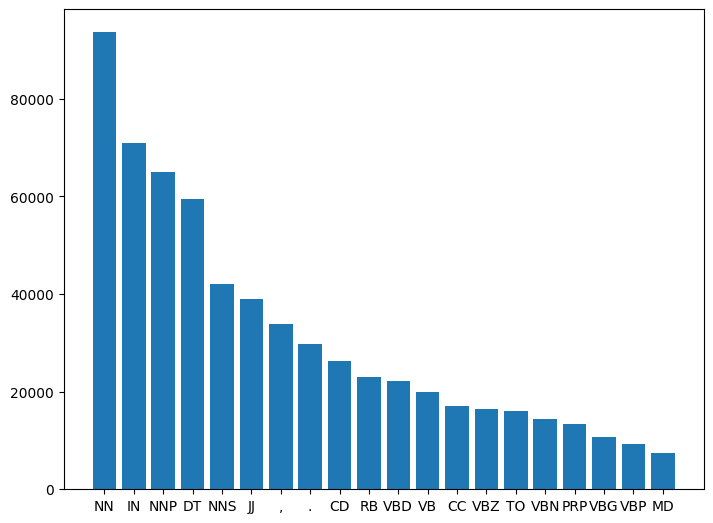

In [24]:
# Your plotting here
import matplotlib.pyplot as plt
from collections import defaultdict
tag_count = defaultdict(int)
for i in range(len(sentences)):
    for tok, tag in zip(sentences[i].split(), postags[i]):
        tag_count[tag]+=1
value_key_pairs = [(value, key) for (key,value) in tag_count.items()]
sorted_value_key_pairs = sorted(value_key_pairs, reverse=True)
x=[]
y=[]
for no,tag in sorted_value_key_pairs[:20]:
    x.append(tag)
    y.append(no)

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x,y)
plt.show()


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

### Task 4 (1 point): Tensorizing sentences
Next, we need to convert our data to numeric form. Convert sentences to their tensor format, as done earlier (this may take a while). 

<div class="alert alert-block alert-info">
<b>Important!</b>
Since the sentences are pre-tokenized with whitespace (e.g., <code>One , two , and three .</code> instead of <code>One, two, and three.</code>), we need to change the processing call to ensure the output vectors are aligned with our tokenization (otherwise SpaCy will tokenize it in its own way and might break the correspondence between tokens and POS tags).
</div>

In [25]:
docs = list(map(
    lambda sentence: spacy.tokens.doc.Doc(nlp.vocab, words=sentence.split()), 
    sentences
))
doc_vectors=[]
doc_tensors=[]
for doc in docs:
    vector=list(map(lambda x: x.vector, doc))
    doc_vectors.append(vector)
    doc_tensors.append(torch.tensor(np.array(vector)))

In [26]:
assert type(doc_tensors) == list
assert doc_tensors[0].shape == torch.Size([45, 300])
assert doc_tensors[1].shape == torch.Size([5, 300])
assert doc_tensors[2].shape == torch.Size([12, 300])

Similarly, we will use `pos_to_int` to convert the POS sequences into tensors.

In [27]:
pos_numeric = list(map(lambda pos_sequence: [pos_to_int[pos] for pos in pos_sequence], postags))
pos_tensors =  list(map(lambda pos_num_sequence: torch.tensor(pos_num_sequence), pos_numeric))

print(type(pos_tensors))
print(pos_tensors[1].shape)
print(pos_tensors[1])

<class 'list'>
torch.Size([5])
tensor([12, 12, 26, 12, 14])


In [28]:
del doc_vectors, docs, pos_numeric

In the tutorial, we saw how to split our dataset into a training and a validation set. 

Do the same here, splitting the sentences, postags and their corresponding tensors into a training and a validation set.  
For the sake of determinism of the training, while splitting data, set shuffling `random_state` to 42 and select 0.2 of the data for validation.  

In [33]:
# !pip install scikit-learn
import sklearn
from sklearn.model_selection import train_test_split
sentences_train, sentences_val, postags_train, postags_val, X_train, X_val, Y_train, Y_val \
    = train_test_split(sentences,postags,doc_tensors,pos_tensors,test_size=0.2,random_state=42)


In [34]:
# TESTING for the sake of deteminism, make sure we have a correct version of the data split 
assert len(X_train) == len(Y_train) == len(sentences_train)
assert len(X_val) == len(Y_val) == len(sentences_val)
assert len(X_train) == 24157
assert len(X_val) == 6040
# 3rd sentence in training set has 36 tokens
assert len(X_train[2]) == 36
# checking pos tag indices of the sannotation of teh 3rd sentence in validation set  
assert torch.all(Y_val[2] == LongTensor([12, 23, 25, 23,  1, 25, 36,  5,  1,  1, 22,  5,  1,  1, 14]))

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

### Task 5 (1 point): Datasets and Padding

Again, following along the tutorial, we will wrap our tensors into a `Dataset` ([link](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset)) and a `DataLoader` ([link](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)).

Since our data are not Tensors but rather Lists of Tensors of uneven lengths, we need to write our own Dataset wrapper.
The wrapper only needs to implement two functions; `__len__`, which expects no arguments and returns the number of samples in the dataset, and `__getitem__`, which accepts an index `idx` and returns the input-output pair `X[idx]`, `Y[idx]`.

Similarly, the Dataloader needs to process the list of input-output pairs produced by the Dataset using `pad_sequence`, as seen earlier.

Fill in the code for `UnevenLengthDataset` class, implementing its two core functions.

<div class="alert alert-block alert-info">
If you have no experience creating container-like classes from scratch in Python, refer to the documentation for the <a href="https://docs.python.org/3/reference/datamodel.html#special-method-names">special class methods</a> and for <a href="https://docs.python.org/3/reference/datamodel.html#emulating-container-types">emulating container types</a>. Talk to your teacher if needed.</div>

Then, complete the function `pad_batch` which takes a list of 
(x$_i$, y$_i$) pairs and produces the pair of their paddings: (X, Y).

Given the two, the `DataLoader` object can iterate over the Dataset yielding uniform batches ready to be consumed by an RNN.

In [38]:
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader


class UnevenLengthDataset(Dataset):
    def __init__(self, X: List[FloatTensor], Y: List[LongTensor]) -> None:
        self.x=X
        self.y=Y
        
    def __len__(self) -> int:
        return len(self.x)
        
    def __getitem__(self, idx: int) -> Tuple[FloatTensor, LongTensor]:
        return self.x[idx], self.y[idx]
    
    
def pad_batch(batch: List[Tuple[FloatTensor, LongTensor]]) -> Tuple[FloatTensor, LongTensor]:
    x=[pair[0] for pair in batch]
    y=[pair[1] for pair in batch]
    x_padding = torch.nn.utils.rnn.pad_sequence(x) 
    y_padding = torch.nn.utils.rnn.pad_sequence(y) 
    return (x_padding,y_padding)

In [39]:
train_dataset = UnevenLengthDataset(X_train, Y_train)
train_dataloader = DataLoader(
    train_dataset, 
    collate_fn=pad_batch,
    shuffle=True, #data will be reshuffled at every epoch
    batch_size=32
)

val_dataset = UnevenLengthDataset(X_val, Y_val)
val_dataloader = DataLoader(
    val_dataset,
    collate_fn=pad_batch,
    shuffle=False,
    batch_size=32
)

What does a batch look like, shape-wise? Get the first element of `train_dataloader` to find out.  
Try to understand what each number in the shape means.  
<font color="blue">_Hint_: 42 is the length of a sequecne in the batch, but why 42? 

In [40]:
# without the seed, every time you run this cell, it will give a random batch
torch.manual_seed(2)
for batch_x, batch_y in train_dataloader:
    print(batch_x.shape)
    print(batch_y.shape)
    break

torch.Size([42, 32, 300])
torch.Size([42, 32])


<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

So far so good. On to the network.

### Task 6 (2 points): Utility Functions
Remember how we defined our training and validation functions in the tutorial?

You will need to do the same here.
Note that while you can use the code from the tutorial for guidance, just copying it won't do the trick; unlike a feedforward net, a recurrent network produces a 3rd order output tensor of shape (max_seq_len, batch_size, num_output_classes).

Similarly, our target Y is a 2nd order tensor of shape (max_seq_len, batch_size).

You will need to properly treat the extra dimension of both the output and the target, since loss functions expect an order 2 output tensor and an order 1 target tensor. 

The functions `accuracy` and `measure_accurace`, which will be needed during evaluation, are already provided to you. 

In [41]:
def accuracy(predictions: LongTensor, truth: LongTensor, ignore_idx: int) -> Tuple[int, int]:
    """
    Compute the total count of non-ignored values and total count of correctly predicted values.
        
    :param predictions: the network's predictions
    :param truth: the true output labels
    :param ignore_idx: the output padding value, to be ignored in accuracy calculation
    :return: the total count of non-ignored values, the total count of correctly predicted values
    """
    correct_words = torch.ones(predictions.size())
    # Zero out the incorrectly predicted values.
    correct_words[predictions != truth] = 0
    # Mark with 1 the values that need to be ignored.
    correct_words[truth == ignore_idx] = 1
    # Calculate the total count of correctly predicted values, incl. the ignored ones.
    num_correct_words = correct_words.sum().item()
    # Calculate the number of the values to be ignored.
    num_masked_words = len(truth[truth == ignore_idx])
    #
    count_non_ignored = predictions.shape[0] * predictions.shape[1] - num_masked_words
    count_correct = num_correct_words - num_masked_words
    return count_non_ignored, count_correct


def measure_accuracy(network: torch.nn.Module, dataloader: DataLoader, device: str) -> float:
    """
    Compute the network's accuracy across all batches.
    
    :param network: the trained network
    :param dataloader: the dataloader for the validation data
    :param device: the device to store the data on ("cpu" or "cuda")
    :return: the network's accuracy
    """
    correct = 0
    total = 0
    # Iterate over the batches.
    for x_batch, y_batch in dataloader:
        # Get the network predictions.
        pred = network(x_batch.to(device))
        # Compute the values to measure accuracy for the current batch.
        # note that pos tags are mapped to numbers 1..48 and we can safely use 0 for making dummy padding slots
        local_total, local_correct = accuracy(pred.argmax(dim=-1), y_batch.to(device), ignore_idx=0)
        # Update the total counts.
        correct += local_correct
        total += local_total
    # Compute the final accuracy across all batches.
    acc = correct/total
    return acc

In [42]:
# If you want to understadn how accuracy works, you can verify these toy input/output pairs 
print(accuracy(LongTensor([[1,2,0,0], [3,4,5,0]]), LongTensor([[1,3,0,0], [1,4,5,0]]), ignore_idx=0))
print(accuracy(LongTensor([[1,2,0,0], [3,4,5,0]]), LongTensor([[1,3,0,0], [1,4,5,0]]), ignore_idx=9))

(5, 3.0)
(8, 6.0)


Complete the functions `train_batch`, `train_epoch`, `eval_batch` and `eval_epoch`.

In [43]:
def train_batch(
    network: torch.nn.Module,
    X_batch: FloatTensor,
    Y_batch: LongTensor,
    loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],  
    optimizer: torch.optim.Optimizer
) -> float: #batch-specific loss
    # YOUR CODE HERE
    raise NotImplementedError()

def train_epoch(
    network: torch.nn.Module, 
    dataloader: DataLoader,
    loss_fn: Callable[[FloatTensor, FloatTensor], FloatTensor],
    optimizer: torch.optim.Optimizer, 
    device: str
) -> float: #epoch's loss
    # YOUR CODE HERE
    raise NotImplementedError()

def eval_batch(
    network: torch.nn.Module,
    X_batch: FloatTensor,
    Y_batch: LongTensor,
    loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor]
) -> float: #batch-specific loss
    # YOUR CODE HERE
    raise NotImplementedError()

def eval_epoch(
    network: torch.nn.Module, 
    dataloader: DataLoader,
    loss_fn: Callable[[FloatTensor, LongTensor], FloatTensor],
    device: str
) -> float: #epoch's loss
    # YOUR CODE HERE
    raise NotImplementedError()

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

### Task 7 (2 points): SRN POS tagging
Define a simple recurrent network, with input size compatible with the vector dimensionality, output size compatible with the number of output classes (the number of different POS tags + 1 due to usig 0 as padding in pos tag annotations) and a hidden size of your own choice.

<ins>Use `"tanh"` as your hidden layer activation</ins>, and choose <ins>an appropriate combination of output activation and loss function</ins> (consider the task at hand and refer to the documentation or the tutorial if in doubt).

Then instantiate an optimizer over your network and train the network for a number of epochs (<ins>at least 3</ins> so that it make sense to plot the results), measuring and printing all metrics in the process (train and validation loss and accuracy).

<font color="blue">_Hint_: Use `measure_accuracy` (defined earlier) to obtain accuracy. For the debugging you can try shorter hidden vectors and a single epoch. 

Plot the loss and accuracy curves over the training process, i.e., x-axis for epoch number and y-axis for loss/accuracy values.

In [ ]:
# for deterministic initialization of weights
torch.manual_seed(0)

srn = NotImplemented
opt = NotImplemented
loss_fn = NotImplemented
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Your training script here
# note that if you don't initialize srn from scratch, running this cell 2nd time will mean 
# training the already trained parameters for further epochs
# Seed makes sure that shuffles in training set is consistent for each run of this cell
torch.manual_seed(0)

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Your loss plotting here: x-axis for epochs and y-axis for train and validation losses

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# Your accuracy plotting here: x-axis for epochs and y-axis for train and validation accuracies

# YOUR CODE HERE
raise NotImplementedError()

The test accuracy on this task should be well over 90%. If you are getting an accuracy much below this, check your code, play with your hyperparameters and try to improve.

<div class="alert alert-block alert-warning">
<b>Show the completed code to your teacher if you have any doubts</b>
</div>

### Task 8 (2 points): Error analysis
<ins>Find 2-4 sentences from the validation set</ins> where the network predicted wrong POS tags. For at least 2 different types of the mistakes, make suggestions as to why they were made. Refer to the [POS tags](https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html) for the POS tag descriptions and the [POS tag annotation guidelines](https://www.cis.upenn.edu/~bies/manuals/tagguide.pdf) which defines when a particular POS tag should and should not be used. 

Write a code that automatically picks such 2-4 sentecnes. Print the sentecne tokens with the corresponding correct and system predicted POS tags in an aligned way that makes readining easy. Make it clear which tag is system predicted and which correct. 

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

### Task 9 (2 points): Extended error analysis

What are the most commonly confused pairs of POS tags (select the top 3-5 pairs)? Provide illustrations from the data and make suggestions as to why these tag pairs are frequently confused.  

Write the code that finds the most confused POS tags pairs. Note that the pairs are not symmetric: one is correct and another system predicted. Make it clear which part of the pair is which. You can use a couple of code cells for printing examples.  

<font color="blue">_Hint_: In top 5 confused pairs, there shoudl be `NN` occuring more than once.  
 

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

YOUR ANSWER HERE

### Congratulations!
🎉 You are done with the required part! 

### Optional

RNNs have limited expressive capacity that can be surpassed by more complicated variants such as [Gated Recurrent Units](https://en.wikipedia.org/wiki/Gated_recurrent_unit) and [Long Short-Term Memory Units](https://en.wikipedia.org/wiki/Long_short-term_memory); replacing your RNN with those could easily improve the performance.

If you found the previous part easy and are already done, you can use other neural architectures to do the same task on the same dataset and compare their performance.  (There will be no support provided for this, or points, but you are welcome to explore this for your own understanding :))

Whatever your design choices are, keep the torch documentation close at all times! Do not reinvent the wheel, use existing abstractions whenever possible (but make sure you use them the right way!). Take measures against overfitting: regularize with dropout and/or weight decay and keep track of the validation set performance to stop training early if needed.